*Luis Antonio Ortega Andrés    
Antonio Coín Castro*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation as anim
from IPython.display import HTML

import search_methods as sm

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Search algorithms for unconstrained optimization

## Dichotomic search

The dichotomic search algorithm is implemented in the function `dichotomic_search` in the file `search_methods.py`. To illustrate the algorithm, we will use the non-differentiable, strictly quasiconvex function

$$
f(x)=\begin{cases}
-2x, & \text{if } x < 0,\\
x^2, & \text{if } x \geq 0,
\end{cases}
$$

which has a minimum at $x=0$.

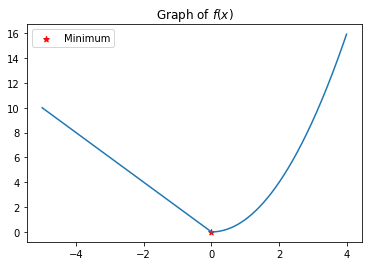

In [2]:
def f(x):
    return np.piecewise(
        x,
        [x < 0, x >= 0],
        [lambda x: -2*x, lambda x: x**2])


a1, b1 = -5, 4

x = np.arange(a1, b1, 0.01)
plt.plot(x, f(x))
plt.title(r"Graph of $f(x)$")
plt.scatter(0, 0, color="red", marker="*", label="Minimum")
plt.legend()
plt.show()

In [3]:
length = 0.001
eps = length/3.
lower, upper, it, evol = sm.dichotomic_search(
    f, a1, b1, eps, length)

print(
    f"After {it} iterations, the minimum is "
    f"contained in [{lower:.4f}, {upper:.4f}].")

After 15 iterations, the minimum is contained in [-0.0002, 0.0007].


Lastly, we show an animation of the evolution of the uncertainty intervals with each iteration.

In [4]:
def get_animation(f, minimum=(0, 0), title="f(x)"):
    """Get animation of the evolution of uncertainty intervals."""
    def update_plot(i, ax):
        # Get uncertainty interval
        lower, upper = evol[i]
        dist = 0.1

        # Clear previous plot
        ax.clear()
        ax.set_title(f"Evolution of uncertainty intervals of ${title}$")
        ax.set_xlim((lower - dist/2, upper + dist/2))

        # Plot uncertainty interval
        ax.scatter(*minimum, color="red", marker="*")
        ax.plot(x, f(x))
        ax.axvline(lower, color="green")
        ax.axvline(upper, color="green")
        ax.axvspan(lower, upper, alpha=0.05, color="green", hatch="/")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    return anim.FuncAnimation(
        fig,
        update_plot,
        frames=len(evol),
        interval=750,
        repeat=False,
        fargs=(ax,)
    )

In [5]:
animation = get_animation(f)
plt.close()
HTML(animation.to_jshtml())

We can also try with another function, say $g(x)=|x-2|+(x-1)^2$, which has a minimum at $x=3/2$.

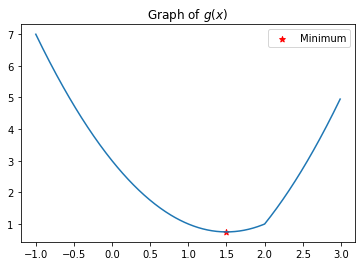

In [6]:
def g(x):
    return np.abs(x - 2) + (x - 1)**2


a1, b1 = -1, 3

x = np.arange(a1, b1, 0.01)
plt.plot(x, g(x))
plt.title(r"Graph of $g(x)$")
plt.scatter(3/2, 3/4, color="red", marker="*", label="Minimum")
plt.legend()
plt.show()

In [7]:
length = 0.001
eps = length/3.
lower, upper, it, evol = sm.dichotomic_search(
    g, a1, b1, eps, length)

print(
    f"After {it} iterations, the minimum is "
    f"contained in [{lower:.4f}, {upper:.4f}].")

After 14 iterations, the minimum is contained in [1.4996, 1.5005].


## Golden-section search

The golden-section search algorithm is implemented in the function `golden_search` in the file `search_methods.py`. We use the same functions as before as test cases.


In [8]:
length = 0.001
lower, upper, it, evol = sm.golden_search(
    f, a1, b1, length)

print(
    f"[f(x)] After {it} iterations, the minimum is "
    f"contained in [{lower:.4f}, {upper:.4f}].")

lower, upper, it, evol = sm.golden_search(
    g, a1, b1, length)

print(
    f"[g(x)] After {it} iterations, the minimum is "
    f"contained in [{lower:.4f}, {upper:.4f}].")

[f(x)] After 18 iterations, the minimum is contained in [-0.0001, 0.0006].
[g(x)] After 18 iterations, the minimum is contained in [1.4998, 1.5006].


Observe that the convergence seems to be slower with this method. We show below the animation of the evolution of the uncertainty intervals for $g(x)$.

In [9]:
animation = get_animation(g, minimum=(3/2, 3/4), title="g(x)")
plt.close()
HTML(animation.to_jshtml())

## Newton's method

Newton's method for optimization is implemented in the function `newton` in the file `search_methods.py`. We implement a *relaxed* method with a fixed learning rate, which follows the iterative scheme

$$
x_{k+1}=x_k - \gamma H^{-1}_f(x_k)\nabla f(x_k), \quad 0 < \gamma \leq 1.
$$

The stopping condition will be double: we will allow a maximum number of iterations, but we will also stop when the difference in norm between two consecutive approximation is smaller than a given tolerance.

On the other hand, we have to be careful when inverting the Hessian matrix. To increase the numerical stability, instead of inverting it directly we calculate it as the solution of the equation $HA=I$, where $I$ is the identity matrix.

To test our implementation, we will try to minimize the function $f(x, y) = (x-2)^4 + (x-2y)^2$, which has a minimum at $(2, 1)$.

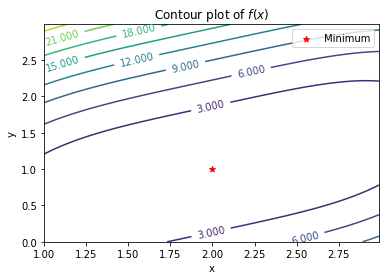

In [10]:
def f(x):
    return (x[0] - 2)**4 + (x[0] - 2*x[1])**2


x0, x1 = 1, 3
y0, y1 = 0, 3
x = np.arange(x0, x1, 0.01)
y = np.arange(y0, y1, 0.01)
xx, yy = np.meshgrid(x, y)
z = f([xx, yy])

# Contour plot
cont = plt.contour(x, y, z, levels=8)
plt.title(r"Contour plot of $f(x)$")
plt.xlabel('x')
plt.ylabel('y')
plt.clabel(cont, inline=True, fontsize=10)
plt.scatter(2, 1, color="red", marker="*", label="Minimum")
plt.legend()
plt.show()

We need to calculate the gradient and the Hessian of $f$. We have

$$
\nabla f(x) = \left( 4(x-2)^3 + 2(x-2y), \ -4(x-2y)\right)^T
$$

and 

$$
H_f(x) = \begin{pmatrix}
12(x-2)^2 + 2 & -4\\
-4 & 8
\end{pmatrix}.
$$

In [11]:
def df(x):
    return np.array([
        4*(x[0] - 2)**3 + 2*(x[0] - 2*x[1]),
        -3*(x[0] - 2*x[1])], dtype=np.float64)


def Hf(x):
    return np.array([
        [12*(x[0] - 2)**2 + 2, -4],
        [-4, 8]], dtype=np.float64)


x0 = np.array([1.2, 2])
sol, it, evol = sm.newton(
    df, Hf, x0, lr=0.8)

print(
    f"After {it} iterations, the minimum is ({sol[0]:.4f}, {sol[1]:.4f}).")

After 37 iterations, the minimum is (2.0000, 1.0000).


Finally, we show the evolution of the sequence $\{x_k\}$ of approximations until the minimum is reached.

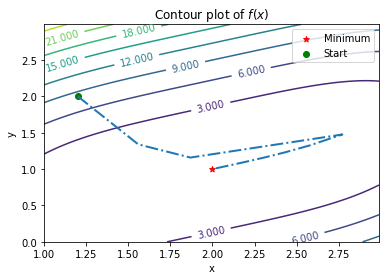

In [12]:
# Contour plot
cont = plt.contour(x, y, z, levels=8)
plt.title(r"Contour plot of $f(x)$")
plt.xlabel('x')
plt.ylabel('y')
plt.clabel(cont, inline=True, fontsize=10)
plt.scatter(2, 1, color="red", marker="*", label="Minimum")
plt.scatter(1.2, 2, color="green", marker="o", label="Start")
plt.plot(evol[:, 0], evol[:, 1], "-.", lw=2)
plt.legend()
plt.show()

### Symbolic differentiation

Finally, we can use the library [Sympy](https://www.sympy.org/en/index.html) for symbolic mathematics. We can automatically calculate the gradient and Hessian of the function $f(x)$ defined above.

In [16]:
from sympy.abc import x, y
from sympy import ordered, Matrix, hessian

eq = (x - 2)**4 + (x - 2*y)**2  # f(x)
v = list(ordered(eq.free_symbols))  # variables

def gradient(f, v):
    return Matrix([f]).jacobian(v)


gradient(eq, v)

Matrix([[2*x - 4*y + 4*(x - 2)**3, -4*x + 8*y]])

In [14]:
hessian(eq, v)

Matrix([
[12*(x - 2)**2 + 2, -4],
[               -4,  8]])

Finally, we re-define the gradient and Hessian of $f$ as functions (without having to explicitly calculate them), and apply Newton's method.

In [15]:
def df(z):
    return np.array(gradient(eq, v).subs([(x, z[0]), (y, z[1])]), dtype=np.float64)[0]


def Hf(z):
    return np.array(hessian(eq, v).subs([(x, z[0]), (y, z[1])]), dtype=np.float64)


x0 = np.array([1.2, 2])
sol, it, evol = sm.newton(
    df, Hf, x0, lr=0.8)

print(
    f"After {it} iterations, the minimum is ({sol[0]:.4f}, {sol[1]:.4f}).")

After 33 iterations, the minimum is (2.0000, 1.0000).
